# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms as T

from scheduler_diffusers import FlowMatchingEulerScheduler

In [2]:
fm_euler_scheduler = FlowMatchingEulerScheduler()

fm_euler_scheduler.set_timesteps(100)

In [3]:
transform = T.Compose([
    T.Lambda(lambda x: x * 2 - 1)
])

inverse_transform = T.Compose([
    T.Lambda(lambda x: (x + 1) / 2)
])

# Our Sample Image $x_1$

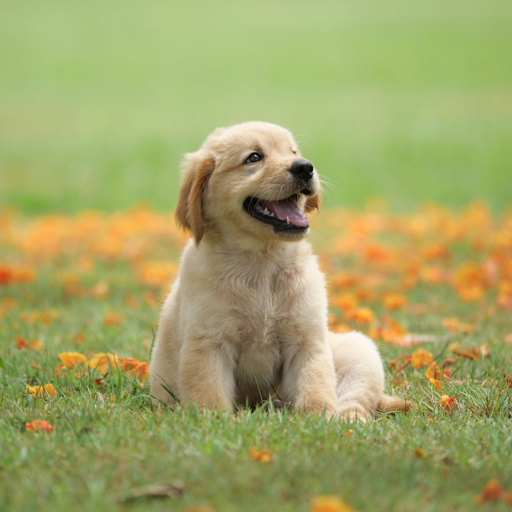

In [4]:
from PIL import Image

image = Image.open("images/dog.jpg").resize((512, 512))
x1 = transform(torch.tensor(np.array(image)).float() / 255).unsqueeze(dim=0)
image

# Our Noise $x_0 \sim N(0, 1)$

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8140795..2.8639183].


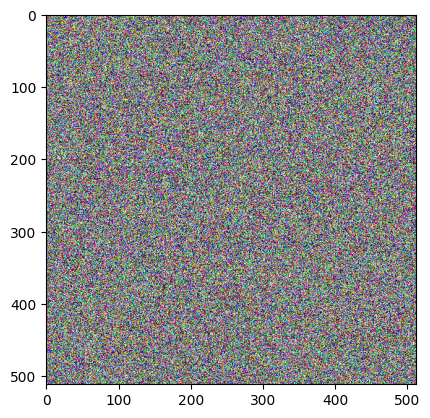

In [11]:
x0 = torch.randn_like(x1)

plt.imshow(inverse_transform(x0[0]))

# Linear interpolations $x_t$ for different timesteps $t$

In [12]:
timesteps = torch.arange(1.1, 0, -0.1)
timesteps

tensor([1.1000, 1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
        0.2000, 0.1000])

In [13]:
noised_samples = torch.cat([fm_euler_scheduler.add_noise(x1, x0, t.unsqueeze(dim=0)) for t in timesteps], dim=0).permute(0, 3, 1, 2)
noised_samples.shape

torch.Size([11, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.574687..2.6198795].


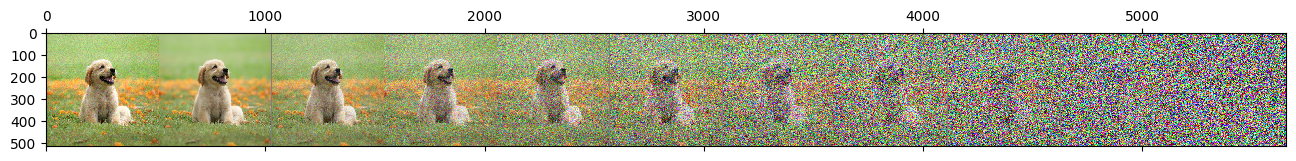

In [14]:
grid = torchvision.utils.make_grid(noised_samples, nrow=11)
grid_np = grid.cpu().numpy().transpose(1, 2, 0)  # channel dim should be last
plt.matshow(inverse_transform(grid_np))

# Denoising (prev sample)

In this "tutorial" we will assume that our model prediction $f(x_t, t)$ is equal to the ideal flow $x_1 - x_0$. Just to make sure that my code works as it should!

In this example Euler Method is used to "generate" an image from noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7869976..2.8395145].


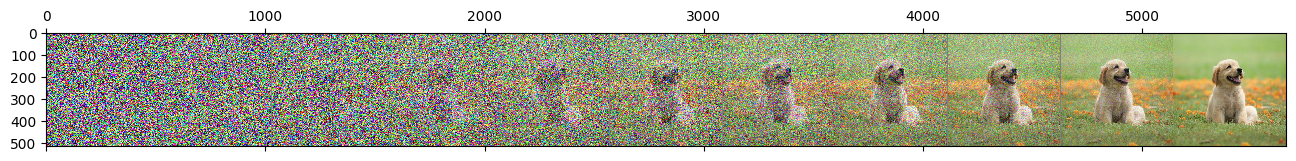

In [16]:
xt = fm_euler_scheduler.add_noise(x1, x0, torch.tensor([0]))

xts = []

for i in range(100):
    xt = fm_euler_scheduler.step(model_output=(x1 - x0), sample=xt, timestep=fm_euler_scheduler.timesteps[i].unsqueeze(dim=0))
    xt = xt.prev_sample

    if i % 10 == 0:
        xts.append(xt)

xts.append(xt)


grid = torchvision.utils.make_grid(torch.cat(xts, dim=0).permute(0, 3, 1, 2), nrow=11)
grid_np = grid.cpu().numpy().transpose(1, 2, 0)
plt.matshow(inverse_transform(grid_np))

# Denoising (original sample)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8140795..2.8639183].


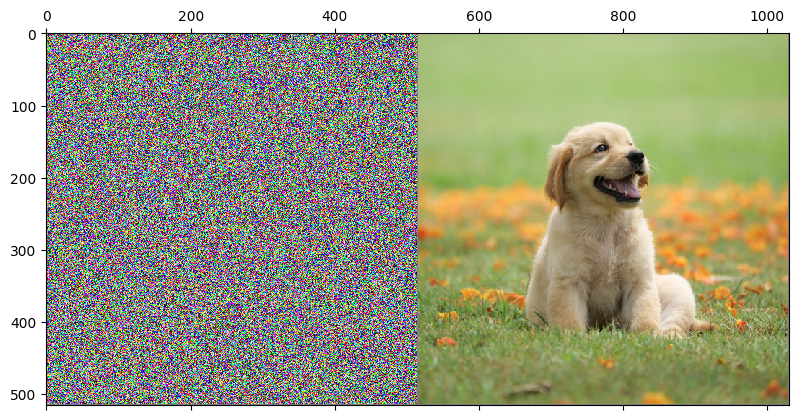

In [17]:
xt_0 = fm_euler_scheduler.add_noise(x1, x0, torch.tensor([0]))

xt_1 = fm_euler_scheduler.step(model_output=(x1 - x0), sample=xt_0, timestep=torch.tensor([0]))


grid = torchvision.utils.make_grid(torch.cat([xt_0, xt_1.pred_original_sample], dim=0).permute(0, 3, 1, 2), nrow=2)
grid_np = grid.cpu().numpy().transpose(1, 2, 0)
plt.matshow(inverse_transform(grid_np))

# You can predict original sample at any time

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7869976..2.8395145].


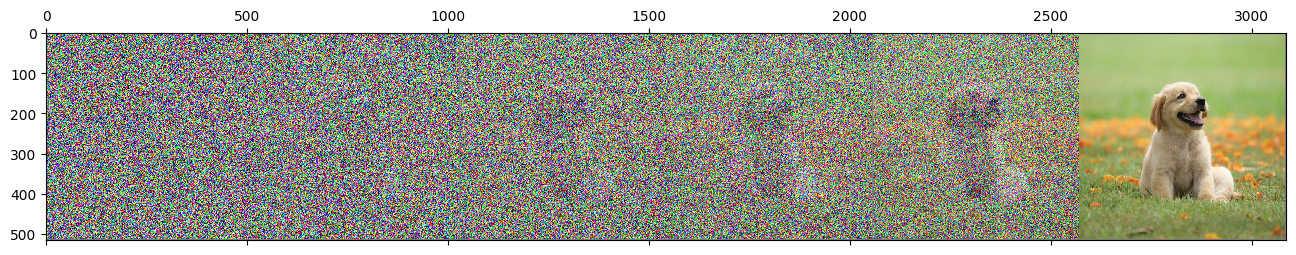

In [19]:
xts = []

xt = fm_euler_scheduler.add_noise(x1, x0, torch.tensor([0]))


for i in range(50):
    xt = fm_euler_scheduler.step(model_output=(x1 - x0), sample=xt, timestep=fm_euler_scheduler.timesteps[i].unsqueeze(dim=0)).prev_sample

    if i % 10 == 0:
        xts.append(xt)
        

xt = fm_euler_scheduler.step(model_output=(x1 - x0), sample=xt, timestep=fm_euler_scheduler.timesteps[50].unsqueeze(dim=0)).pred_original_sample
xts.append(xt)

grid = torchvision.utils.make_grid(torch.cat(xts, dim=0).permute(0, 3, 1, 2), nrow=11)
grid_np = grid.cpu().numpy().transpose(1, 2, 0)
plt.matshow(inverse_transform(grid_np))